Informations:
* Data collecting tool: **Atop**  
* Features extraction tool: **Atop**

In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json

folder = os.path.join("..", "0_dataset", "accounting")
filenames = ['label_atop_mirai.csv', 'label_atop_disk_wipe.csv', 'label_atop_ransomware.csv',
                  'label_atop_resource_hijacking.csv', 'label_atop_end_point_dos.csv']
filename_label = 'preprocess_label_atop.csv'
label_table_path = 'labels_table.json'

ImportError: cannot import name 'pyplot'

1. Preprocessing

In [14]:
one_hot_col_list = ['POLI', 'ST', 'EXC', 'S']
# removed_fields = ['TIMESTAMP', 'PID', 'CMD', 'Hostname', 'Tactic', 'Technique', 'SubTechnique']
removed_fields = ['PID', 'CMD', 'Hostname', 'Tactic', 'Technique', 'SubTechnique']
replace_strings = {'%': '', 'K': '000', 'M': '000000', 'G': '000000000'}
remove_rows_with_str = {'-': '0'}

df = pd.DataFrame()
for tmp_filename in filenames:
    print("\n")
    print("-------------------------------------\n")
    print("file name:{0}".format(tmp_filename))
    filename = os.path.join(folder, tmp_filename)
    tmp_df = pd.read_csv(filename)

    # simple analysis
    labels = tmp_df['Label'].unique()
    print('labels: {0}'.format(labels))
    
    df = df.append(tmp_df)

# delete useless features
df.drop(columns=removed_fields, axis=1, inplace=True)

# one-hot-encoding
df = pd.get_dummies(df, columns=one_hot_col_list)

df.drop_duplicates(keep=False, inplace=True)

# string replacement
for old_value, new_value in replace_strings.items():
    df = df.replace(to_replace=old_value, value=new_value, regex=True)
for old_value, new_value in remove_rows_with_str.items():
    df = df.replace(to_replace=old_value, value=new_value)

# turn to number
for k in list(df):
    df[k] = pd.to_numeric(df[k], errors='ignore')

output_filename = os.path.join(folder, filename_label)
df.to_csv(output_filename, encoding='utf-8', index=False)



-------------------------------------

file name:label_atop_mirai.csv
labels: [ 0  1  2  3  5  9 11 12]


-------------------------------------

file name:label_atop_disk_wipe.csv
labels: [ 0  1  2  4  6  8 14]


-------------------------------------

file name:label_atop_ransomware.csv
labels: [ 0  1  4  6  7 12 15]


-------------------------------------

file name:label_atop_resource_hijacking.csv
labels: [ 0  1  2  6  8 16]


-------------------------------------

file name:label_atop_end_point_dos.csv
labels: [ 0 17  2]


2. Visualization (data number)


Data number:
class0: 97549
class1: 91
class2: 550
class3: 478
class4: 171
class5: 720
class6: 2065
class7: 3973
class8: 8314
class9: 10
class11: 1322
class12: 3554
class14: 1980
class15: 1626
class16: 2285
class17: 2350


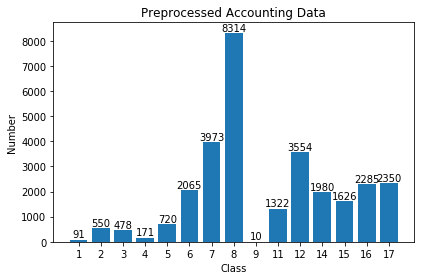

In [31]:
def bar_class_num(technique_data_size):
    class_num = np.arange(len(technique_data_size))
    # data_nums = plt.bar(class_num, technique_data_size, 0.2)
    data_nums = plt.bar(class_num, technique_data_size)
    for item in data_nums:
        height = item.get_height()
        plt.text(
            item.get_x()+item.get_width()/2., 
            height, 
            '%d' % int(height),
            ha = "center",
            va = "bottom",
        )
    labels.pop(0)
    plt.xticks(class_num, labels)
    plt.xlabel("Class")
    plt.ylabel("Number")
    plt.title("Preprocessed Accounting Data")
    plt.tight_layout()
    plt.savefig("accounting.png", dpi=400)
    plt.show()

technique_data_size = []
df = pd.read_csv(os.path.join(folder, "select_"+filename_label))
labels = df['Label'].unique()
labels = [int(i) for i in labels]
labels.sort()
with open("labels_table.json", "r") as f:
    label_table = json.load(f)

for i in labels:
    if i != 0:
        class_data_size = len(df[df['Label'] == i])
        technique_data_size.append(class_data_size)

print("\nData number:")
for i in labels:
    print("class{0}: {1}".format(i, len(df[df['Label'] == i])))

bar_class_num(technique_data_size)

3. Feature selection
    * remove duplicated
    * remove similar features

In [30]:
df = pd.read_csv(os.path.join(folder, filename_label))
del_list = ['TIMESTAMP']

print("origin data number: {0}".format(len(df.index)))
print("origin features: {0}".format(len(df.columns)-1))


# drop duplicated
df.drop_duplicates(keep=False, inplace=True)
df.drop(columns=del_list, inplace=True)


# drop similar
df_tmp1 = df.drop(columns=['Label'])
corr_features = set()
corr_matrix = df_tmp1.corr()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            colname = corr_matrix.columns[i]
            corr_features.add(colname)

df.drop(labels=corr_features, axis=1, inplace=True)
# df.drop_duplicates(keep=False, inplace=True)

# drop duplicate for normal data
df_tmp2 = df.loc[df['Label'] == 0].copy()
df_tmp2.drop_duplicates(keep=False, inplace=True)
df.drop(df[df['Label'] == 0].index, inplace=True)
df = pd.concat([df, df_tmp2])


print("remain data number: {0}".format(len(df.index)))
print("remain features: {0}".format(len(df.columns)-1))

output_file = os.path.join(folder, "select_"+filename_label)
df.to_csv(output_file, encoding='utf-8', index=False)

origin data number: 7758541
origin features: 50
remain data number: 127038
remain features: 39
